# import

In [322]:
import time

import torch
import numpy as np
import pandas as pd

from tqdm import tqdm
import matplotlib.pyplot as plt


print(torch.cuda.is_available())

True


In [324]:
!nvidia-smi

Sat Dec 16 16:45:15 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0              30W /  70W |   2809MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [288]:
from src.sinkhorn import Sinkhorn
from src.sinkhorn_gpu import SinkhornGPU

# compare Sinkhorn & SinkhornGPU

In [315]:
def generate_input(dim: int) -> bool:
    """
    todo
    """
    gammaT_ij = torch.rand((dim, dim))
    lambda_w_j = torch.rand((dim,))
    lambda_l_i = torch.rand((dim,))
    return gammaT_ij, lambda_w_j, lambda_l_i

In [321]:
gammaT_ij, lambda_w_j, lambda_l_i = generate_input(100)

sinkhorn_numpy = Sinkhorn(lambda_w_j.numpy(), lambda_l_i.numpy(), max_iter=5)
sinkhorn_cpu = SinkhornGPU(lambda_w_j, lambda_l_i, device="cpu", max_iter=5)

k = 0
lambda_w_j_numpy, lambda_l_i_numpy = sinkhorn_numpy._scipy_iteration(k, gammaT_ij, lambda_w_j, lambda_l_i)
lambda_w_j_cpu, lambda_l_i_cpu = sinkhorn_cpu._iteration(k, gammaT_ij, lambda_w_j, lambda_l_i)

In [318]:
assert np.linalg.norm(lambda_w_j_numpy - lambda_w_j_cpu.numpy()) < 1e-3
assert np.linalg.norm(lambda_l_i_numpy - lambda_l_i_cpu.numpy()) < 1e-3

# profile Sinkhorn & SinkhornGPU

In [226]:
def measure_execution_time(sinkhorn: object, *args, **kwargs) -> float:
    """
    todo
    """
    t0 = time.perf_counter()
    _ = sinkhorn.run(*args, **kwargs)
    return time.perf_counter() - t0


def get_execution_time(dim: int, max_iter: int) -> dict[str, float]:
    """
    todo
    """
    # NOTE: synthetic test
    gammaT_ij = torch.rand((dim, dim))
    departures, arrivals = torch.rand((dim,)), torch.rand((dim,))

    sinkhorn_numpy = Sinkhorn(departures.numpy(), arrivals.numpy(), max_iter=max_iter)
    t_numpy = measure_execution_time(sinkhorn_numpy, gammaT_ij=gammaT_ij.numpy())

    sinkhorn_cpu = SinkhornGPU(departures, arrivals, device="cpu", max_iter=max_iter)
    t_cpu = measure_execution_time(sinkhorn_cpu, gammaT_ij=gammaT_ij)

    sinkhorn_cuda = SinkhornGPU(departures, arrivals, device="cuda", max_iter=max_iter)
    t_cuda = measure_execution_time(sinkhorn_cuda, gammaT_ij=gammaT_ij)

    return {
        "t_numpy": t_numpy,
        "t_cpu": t_cpu,
        "t_cuda": t_cuda,
    }


def get_execution_time_log(linspace: np.ndarray, max_iter: int) -> pd.DataFrame:
    """
    todo
    """
    records = np.array([get_execution_time(dim, max_iter) for dim in tqdm(linspace)])
    return pd.DataFrame.from_records(records, index=linspace)


def apply_ma(
    df: pd.DataFrame, columns: list = [], window_size: int = 10
) -> pd.DataFrame:
    """
    Applies moving average to the columns of the pd.DataFrame
    """
    if not columns:
        columns = df.columns

    for column in columns:
        df[f"ma_{column}"] = df[column].rolling(window=window_size).mean()
    return df


In [227]:
linspace = np.linspace(10, 10_000, 100).astype(int)
df = get_execution_time_log(linspace, 5)

100%|██████████| 100/100 [09:31<00:00,  5.72s/it]


In [276]:
df["t_numpy_t_cuda"] = df["t_numpy"] / df["t_cuda"]
df["t_numpy_t_cpu"] = df["t_numpy"] / df["t_cpu"]

ma_df = apply_ma(df, window_size=10).fillna(method='bfill')

# plot

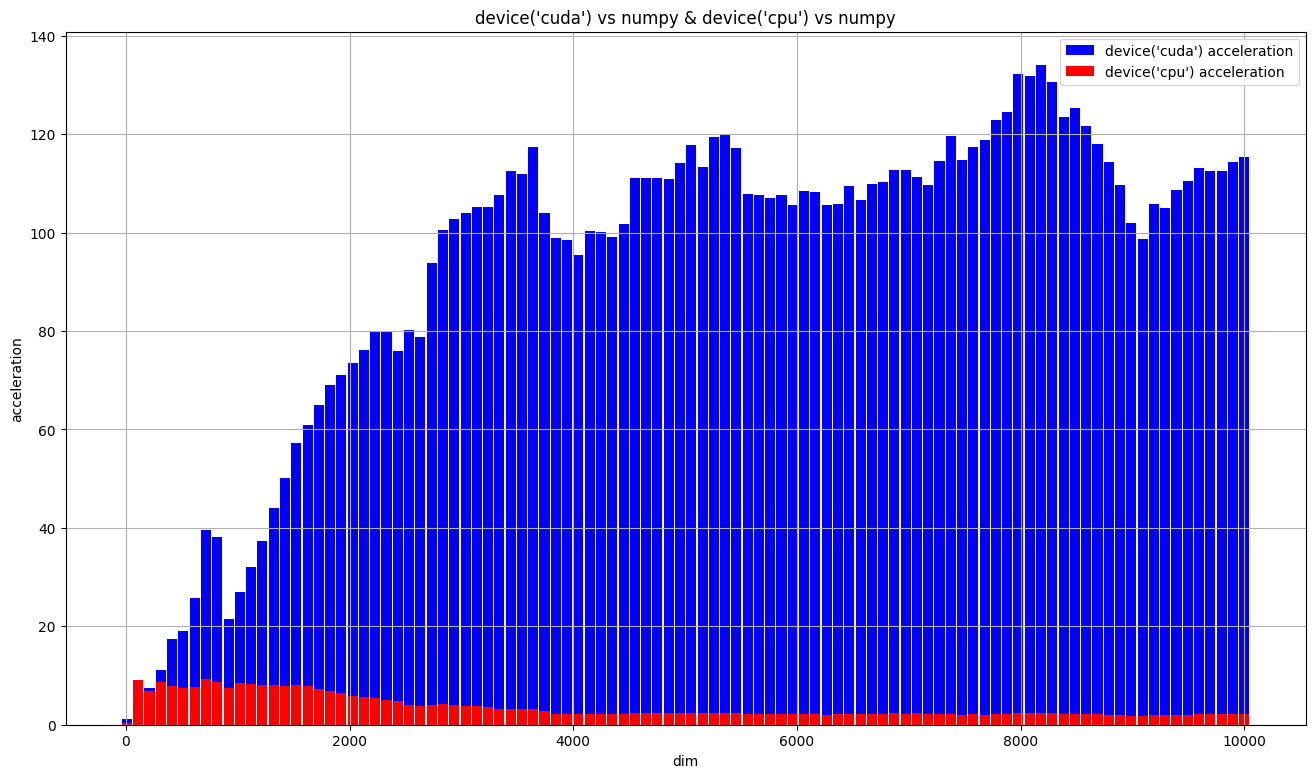

In [286]:
fig, ax = plt.subplots(figsize=(16, 9))

keys = ma_df.index

ax.bar(keys, ma_df["ma_t_numpy_t_cuda"].fillna(ma_df["t_numpy_t_cuda"]), label = "device('cuda') acceleration", width=90, color="b")
ax.bar(keys, ma_df["ma_t_numpy_t_cpu"].fillna(ma_df["t_numpy_t_cpu"]), label = "device('cpu') acceleration", width=90, color="r")

ax.grid()
ax.set_title("device('cuda') vs numpy & device('cpu') vs numpy")
ax.set_xlabel("dim")
ax.set_ylabel("acceleration")

ax.legend()
plt.savefig(f'sinkhorn.png', dpi=300)